In [1]:
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False 

## 1. 데이터가져오기

In [2]:
import pandas as pd

weather_data = pd.read_csv("./data/weather_data.csv", encoding='CP949')

# 컬럼이름 변경
weather_data.columns = weather_data.columns.str.replace('bigcon_weather.','')

gs25_data = pd.read_csv("./data/GS25.csv", encoding='CP949')

# 컬럼이름 변경
gs25_data.columns = gs25_data.columns.str.replace('korea_cvs.','')

## 2. 데이터전처리
서울특별시 서대문구에 대한 데이터 분석을 하고 싶었지만, 상대습도에 대한 데이터 결측치가 많아 결측치가 거의 없는 종로구를 선택하여 분석함.

In [3]:
#데이터 필터링
weather = weather_data[(weather_data['pvn_nm']=='서울특별시') & (weather_data['bor_nm']=='종로구')]
gs25 = gs25_data[(gs25_data['pvn_nm']=='서울특별시') & (gs25_data['bor_nm']=='종로구')]

#데이터 결측치 처리 
weather['avg_ws'].fillna(value=0, inplace=True)
weather['sum_rn'].fillna(value=0, inplace=True)

#필요없는 특성삭제
gs25 = gs25.drop(['pvn_nm', 'bor_nm'], axis='columns')
weather = weather.drop(['pvn_nm', 'bor_nm','stn_id','max_ta','max_ws','min_ta'], axis='columns')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [221]:
gs25.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54295 entries, 0 to 2519456
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sale_dt   54295 non-null  int64 
 1   gen_cd    54295 non-null  object
 2   age_cd    54295 non-null  object
 3   category  54295 non-null  object
 4   adj_qty   54295 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 2.5+ MB


In [222]:
gs25['age_cd'].value_counts()

20~39    21014
40~59    17919
00~19     8686
60~99     6676
Name: age_cd, dtype: int64

In [223]:
pd.unique(gs25['category'])

array(['라면', '과자', '마스크', '맥주', '생리대', '생수', '숙취해소제', '스타킹', '아이스크림',
       '탄산음료', '면도기', '우산'], dtype=object)

In [225]:
#weather.isna().sum()/len(weather)

## 3. (상품중심)데이터 머지 및 상관관계분석
avg_ta(평균기온) 맥주, 생수, 아이스크림, 탄산음료

avg_rhm(평균상대습도) 우산

기상 변화와 고객 특성 간에 상관관계 도출

기상 변화와 고객 특성으로 판매되는 상품(량)을 예측

고객 특성에 따라 판매되는 상품 도출
(기상 변화와 양의 상관관계가 있는 상품들과 고객 특성과의 관계 분석)

In [9]:
import numpy as np
gs25_pivot = pd.pivot_table(gs25, values='adj_qty', index='sale_dt', columns='category', aggfunc=np.sum, fill_value=0)

gs25_pivot2 = gs25_pivot.copy()
gs25_pivot2.columns = gs25_pivot2.columns.values
gs25_pivot2.reset_index(level=0, inplace=True)
gs25_pivot2 = gs25_pivot2.rename({'sale_dt':'tm'}, axis='columns')

In [10]:
new_data = weather.merge(gs25_pivot2, on='tm', how='left')
new_date_rename = new_data.rename({'tm':'일자','avg_ta':'평균기온','avg_rhm':'평균상대습도','avg_ws':'평균풍속','sum_rn':'합계강수량'}, axis='columns')

In [6]:
corr_matrix = new_date_rename.corr()
corr = corr_matrix.loc['평균기온':'탄산음료','평균기온':'탄산음료']

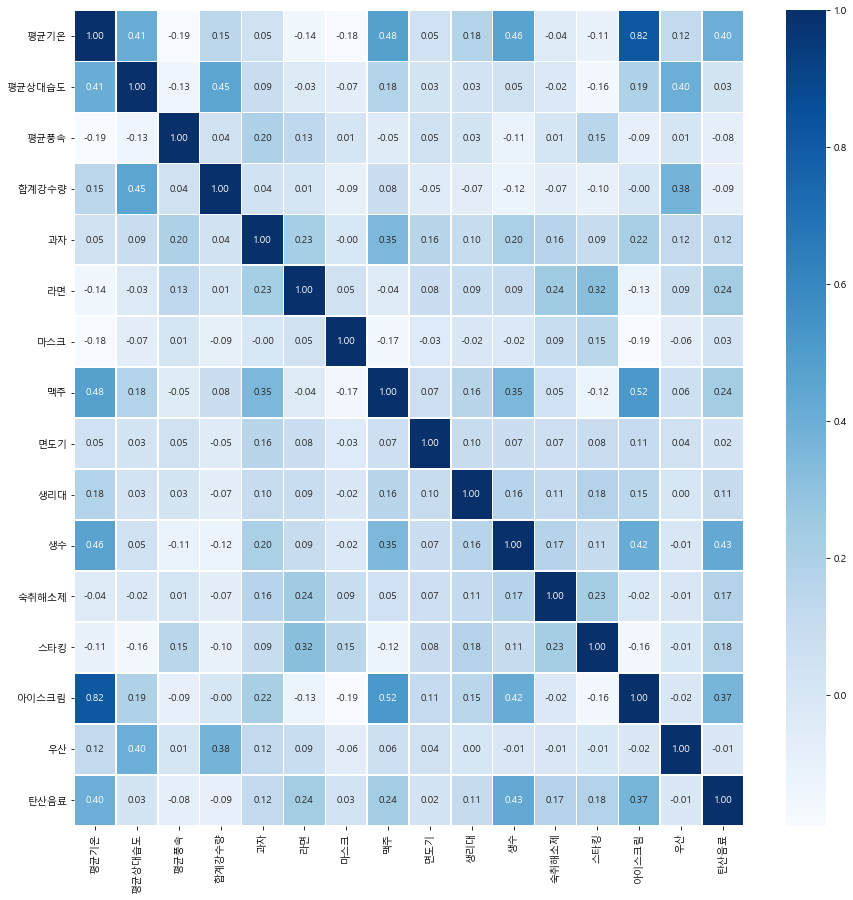

In [13]:
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.figure(figsize=(15,15))
sns.heatmap(data = corr, annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')
plt.savefig('weather_prod_corr.png')

## 4. (고객특성중심)데이터머지 및 상관관계분석

In [14]:
import numpy as np

gs25_season = gs25[gs25['category'].isin(['맥주', '생수','아이스크림','탄산음료','우산'])]
gs25_custom_pivot = pd.pivot_table(gs25_season, values='adj_qty', index='sale_dt', columns=['gen_cd','age_cd'], aggfunc=np.sum, fill_value=0)

gs25_custom_pivot2 = gs25_custom_pivot.copy()
gs25_custom_pivot2.columns = gs25_custom_pivot2.columns.values
gs25_custom_pivot2.reset_index(level=0, inplace=True)
gs25_custom_pivot2 = gs25_custom_pivot2.rename({'sale_dt':'tm'}, axis='columns')

In [15]:
x = gs25_custom_pivot2.columns
nm = []
for i in gs25_custom_pivot2:  
    if (i !='tm' ):
        nm.append(i[0] +'_'+ i[1])
    else:
        nm.append(i)   

In [16]:
gs25_custom_pivot2.columns = nm
new_custom_data = weather.merge(gs25_custom_pivot2, on='tm', how='left')

In [8]:
"""
new_custom_data.iloc[:,5:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
new_custom_data.iloc[:,5:] = scaler.fit_transform(new_custom_data.iloc[:,5:])
"""

In [17]:
new_cust_data_rename = new_custom_data.rename({'tm':'일자','avg_ta':'평균기온','avg_rhm':'평균상대습도','avg_ws':'평균풍속','sum_rn':'합계강수량'}, axis='columns')

In [57]:
corr_custom_matrix = new_cust_data_rename.corr()
corr_custom_matrix.loc['평균기온':'합계강수량','F_00~19':'M_60~99']

,F_00~19,F_20~39,F_40~59,F_60~99,M_00~19,M_20~39,M_40~59,M_60~99
평균기온,0.425117,0.754402,0.687100,0.469198,0.226510,0.707737,0.692696,0.360725
평균상대습도,0.115709,0.233214,0.192122,0.123173,0.020037,0.168507,0.213720,0.123917
평균풍속,0.015155,-0.087352,-0.137947,-0.096554,-0.004737,-0.056124,-0.068540,-0.192133
합계강수량,-0.036205,0.027030,0.018926,0.004184,-0.008949,0.021472,0.034619,0.087497


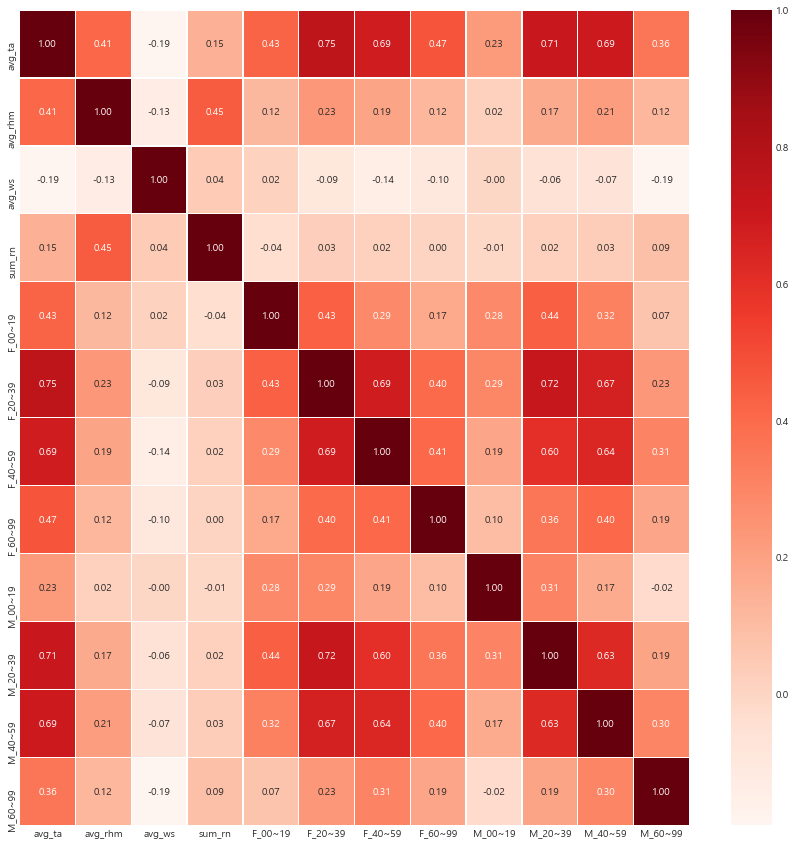

In [45]:
import matplotlib.pyplot as plt 
import seaborn as sns 

plt.figure(figsize=(15,15))
sns.heatmap(data = corr_custom_matrix.loc['avg_ta':,'avg_ta':], annot=True, 
fmt = '.2f', linewidths=.5, cmap='Reds')
plt.savefig('weather_custom_corr.png')

In [18]:
import pandas as pd
import pandas_datareader.data as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')

import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

%matplotlib inline

from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False 

## 5. 기상과 상관관계가 있는 제품에 대한 시계열 분석
new_date_rename

new_cust_date_rename

In [42]:
new_date_rename.head(10)

,일자,평균기온,평균상대습도,평균풍속,합계강수량,과자,라면,마스크,맥주,면도기,생리대,생수,숙취해소제,스타킹,아이스크림,우산,탄산음료
0,20160101,1.2,73.0,1.6,0.0,1500,818,56,499,7,85,274,35,28,514,0,98
1,20160102,5.7,77.0,2.0,0.0,1536,718,21,514,0,141,281,49,21,366,0,126
2,20160103,6.5,81.0,1.8,0.0,1437,853,14,380,42,77,345,21,28,578,0,105
3,20160104,2.0,54.0,3.1,0.0,1297,973,7,282,14,113,217,14,14,401,0,147
4,20160105,-2.7,39.0,2.3,0.0,1395,937,0,360,7,77,253,105,35,408,0,77
5,20160106,-1.7,54.0,1.8,0.0,1260,895,0,295,0,63,282,162,42,218,0,70
6,20160107,-3.4,52.0,2.5,0.0,1169,1015,7,204,14,84,288,197,35,458,0,105
7,20160108,-3.3,50.0,2.0,0.0,1740,1043,0,373,21,113,267,310,63,528,0,98
8,20160109,-2.1,57.0,2.1,0.0,1635,831,21,521,7,77,331,56,0,451,0,105
9,20160110,0.3,42.0,2.6,0.0,1607,1078,14,380,21,126,352,70,35,556,7,91


In [43]:
new_cust_data_rename.head(10)

,일자,평균기온,평균상대습도,평균풍속,합계강수량,F_00~19,F_20~39,F_40~59,F_60~99,M_00~19,M_20~39,M_40~59,M_60~99
0,20160101,1.2,73.0,1.6,0.0,0,485,168,28,0,408,296,0
1,20160102,5.7,77.0,2.0,0.0,28,486,126,35,7,387,218,0
2,20160103,6.5,81.0,1.8,0.0,0,591,267,21,7,247,275,0
3,20160104,2.0,54.0,3.1,0.0,0,345,330,28,14,204,126,0
4,20160105,-2.7,39.0,2.3,0.0,14,353,211,21,7,387,91,14
5,20160106,-1.7,54.0,1.8,0.0,7,352,190,0,7,232,77,0
6,20160107,-3.4,52.0,2.5,0.0,7,528,211,21,7,162,119,0
7,20160108,-3.3,50.0,2.0,0.0,14,486,302,14,0,338,112,0
8,20160109,-2.1,57.0,2.1,0.0,14,486,240,21,28,507,112,0
9,20160110,0.3,42.0,2.6,0.0,35,486,387,0,21,352,105,0


### 모델 만들기 

In [19]:
new_date_rename['일자'] = new_date_rename['일자'].astype(str)
new_date_rename['일자'] = pd.to_datetime(new_date_rename['일자'])
new_date_rename['일자'] = new_date_rename['일자'].dt.tz_localize('UTC')

new_cust_data_rename['일자'] = new_cust_data_rename['일자'].astype(str)
new_cust_data_rename['일자'] = pd.to_datetime(new_cust_data_rename['일자'])
new_cust_data_rename['일자'] = new_cust_data_rename['일자'].dt.tz_localize('UTC')

In [26]:
FEATURENAME = '아이스크림'
date_feature = new_date_rename[['일자',FEATURENAME]].set_index('일자')
date_feature

,아이스크림
일자,
2016-01-01 00:00:00+00:00,514
2016-01-02 00:00:00+00:00,366
2016-01-03 00:00:00+00:00,578
2016-01-04 00:00:00+00:00,401
2016-01-05 00:00:00+00:00,408
...,...
2018-12-27 00:00:00+00:00,415
2018-12-28 00:00:00+00:00,296
2018-12-29 00:00:00+00:00,232


In [27]:
data_feature_tree = new_date_rename[['일자','평균기온','평균상대습도','평균풍속','합계강수량',FEATURENAME]].set_index('일자')
data_feature_tree

,평균기온,평균상대습도,평균풍속,합계강수량,아이스크림
일자,,,,,
2016-01-01 00:00:00+00:00,1.2,73.0,1.6,0.0,514
2016-01-02 00:00:00+00:00,5.7,77.0,2.0,0.0,366
2016-01-03 00:00:00+00:00,6.5,81.0,1.8,0.0,578
2016-01-04 00:00:00+00:00,2.0,54.0,3.1,0.0,401
2016-01-05 00:00:00+00:00,-2.7,39.0,2.3,0.0,408
...,...,...,...,...,...
2018-12-27 00:00:00+00:00,-10.1,28.0,3.5,0.0,415
2018-12-28 00:00:00+00:00,-10.5,33.0,2.5,0.0,296
2018-12-29 00:00:00+00:00,-7.6,29.0,2.9,0.0,232


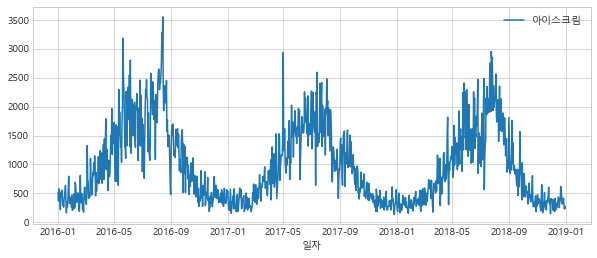

In [28]:
plt.figure(figsize=(10,4))
sns.lineplot(data=date_feature)
plt.savefig(f'date_feature_lineplot_{FEATURENAME}.png')

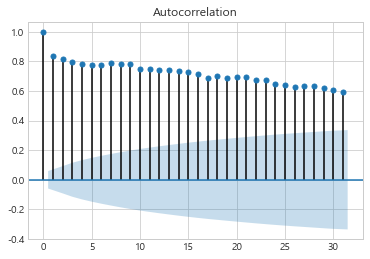

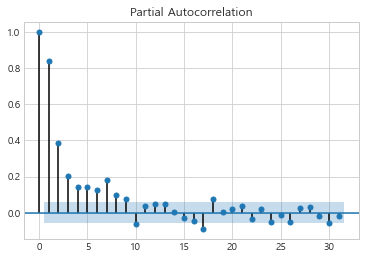

In [29]:
plot_acf(date_feature)
plot_pacf(date_feature)
#plt.show()
plt.savefig(f'date_feature_acf_{FEATURENAME}.png')

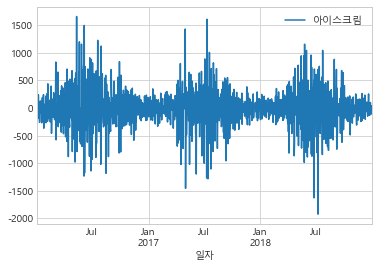

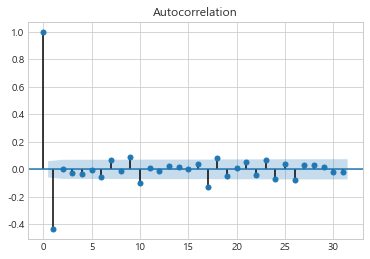

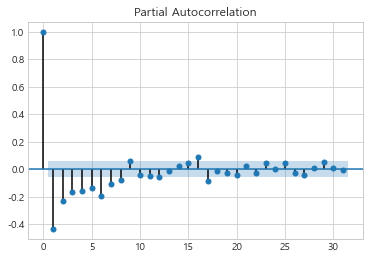

<Figure size 432x288 with 0 Axes>

In [30]:
diff_1 = date_feature.diff(periods=1).iloc[1:]
diff_1.plot()
plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()
plt.savefig(f'date_feature_diff_acf_{FEATURENAME}.png')

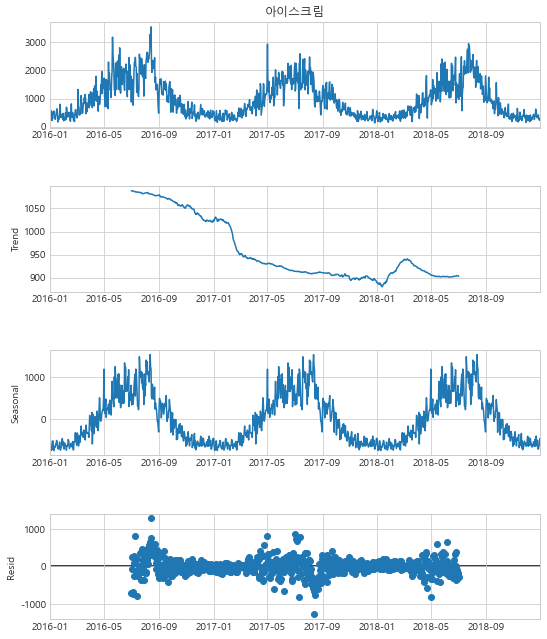

In [31]:
docompostion = seasonal_decompose(date_feature[FEATURENAME], model='additive',period=365)
fig = docompostion.plot()
fig.set_size_inches(8,10)
#plt.show()
plt.savefig(f'date_feature_docompostion_{FEATURENAME}.png')

In [133]:
train_data, test_data = train_test_split(date_feature, test_size=0.05, shuffle=False)

In [134]:
test_data

,아이스크림
일자,
2018-11-07 00:00:00+00:00,246
2018-11-08 00:00:00+00:00,196
2018-11-09 00:00:00+00:00,450
2018-11-10 00:00:00+00:00,648
2018-11-11 00:00:00+00:00,472
2018-11-12 00:00:00+00:00,162
2018-11-13 00:00:00+00:00,239
2018-11-14 00:00:00+00:00,217
2018-11-15 00:00:00+00:00,360


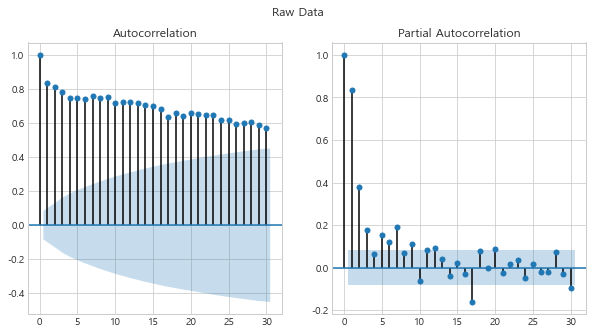

In [121]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Raw Data")
plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1]);
plt.savefig(f'train_data_acf_{FEATURENAME}.png')

In [135]:
#Differencing

diff_train_data = train_data.copy()
diff_train_data = diff_train_data[FEATURENAME].diff()
diff_train_data = diff_train_data.dropna()
print("########## Raw Data #########")
print(train_data)
print("######### Differenced Data ####")
print(diff_train_data)


########## Raw Data #########
                           아이스크림
일자                              
2016-01-01 00:00:00+00:00    514
2016-01-02 00:00:00+00:00    366
2016-01-03 00:00:00+00:00    578
2016-01-04 00:00:00+00:00    401
2016-01-05 00:00:00+00:00    408
...                          ...
2018-11-02 00:00:00+00:00    318
2018-11-03 00:00:00+00:00    373
2018-11-04 00:00:00+00:00    407
2018-11-05 00:00:00+00:00    395
2018-11-06 00:00:00+00:00    337

[1041 rows x 1 columns]
######### Differenced Data ####
일자
2016-01-02 00:00:00+00:00   -148.0
2016-01-03 00:00:00+00:00    212.0
2016-01-04 00:00:00+00:00   -177.0
2016-01-05 00:00:00+00:00      7.0
2016-01-06 00:00:00+00:00   -190.0
                             ...  
2018-11-02 00:00:00+00:00   -161.0
2018-11-03 00:00:00+00:00     55.0
2018-11-04 00:00:00+00:00     34.0
2018-11-05 00:00:00+00:00    -12.0
2018-11-06 00:00:00+00:00    -58.0
Name: 아이스크림, Length: 1040, dtype: float64


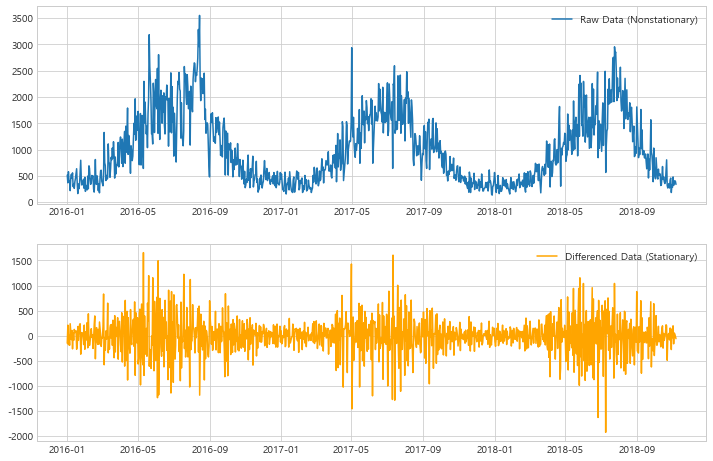

In [136]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data[FEATURENAME])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (Stationary)'])
#plt.show()
plt.savefig(f'train_data_diff_{FEATURENAME}.png')

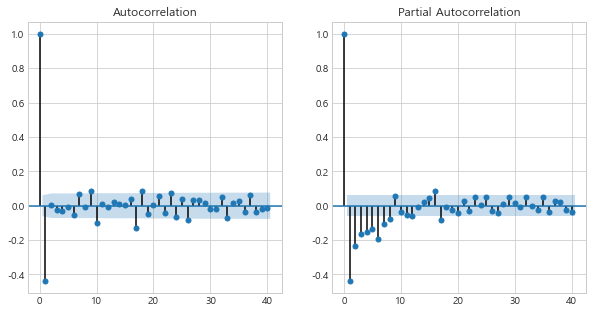

In [137]:
flg, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle("Differenced Data")
plot_acf(diff_train_data.values.squeeze(), lags=40, ax=ax[0])
plot_pacf(diff_train_data.values.squeeze(), lags=40, ax=ax[1]);
plt.savefig(f'train_data_diff_acf_{FEATURENAME}.png')

In [145]:
model = ARIMA(train_data.values, order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1040
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -7512.700
Method:                       css-mle   S.D. of innovations            331.841
Date:                Thu, 10 Dec 2020   AIC                          15033.399
Time:                        15:01:26   BIC                          15053.187
Sample:                             1   HQIC                         15040.906
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1090      5.818     -0.019      0.985     -11.512      11.295
ar.L1.D.y     -0.5385      0.030    -17.859      0.000      -0.598      -0.479
ar.L2.D.y     -0.2310      0.030     -7.665      0.0

In [47]:
model_fit.predict(3)

array([-7.48523809e+01,  5.85674910e+01,  1.98072512e+01,  1.31839722e+02,
       -7.39627265e+01, -7.98667856e+01, -1.24166856e+01, -4.29713665e+01,
        1.26437812e+02,  3.36418947e+01,  7.48124202e+01, -4.89386305e+01,
       -5.74694015e+01, -8.24314613e+01, -8.72278469e+01,  1.08369657e+02,
        1.81024311e+02,  2.80452390e+00,  2.85276886e+01, -4.40629652e+01,
       -1.29378118e+02, -2.08419958e+02,  9.97953395e+01,  1.34610247e+02,
        5.40217010e+01, -1.26538053e+01, -2.85168531e+01,  8.82175237e+01,
       -6.62916381e+01,  1.13273635e+02,  8.16453829e+00,  6.98405865e-01,
        2.67274406e+01, -1.22094322e+02,  6.91848617e+01, -2.05821683e+02,
       -6.63502961e+01,  5.68671168e+01,  1.29236783e+02,  4.95980357e+01,
       -6.69972842e+01, -2.83035920e+01, -2.23201996e+01,  1.39769538e+02,
        1.06682202e+02, -6.64994380e+01, -2.74812395e+02,  1.02854847e+02,
        8.86933882e+01, -1.35908500e+01,  1.75253202e+01,  1.04930463e+02,
        4.29945202e-02,  

In [147]:
forecast_data = model_fit.forecast(steps=len(test_data)) # 학습 데이터셋으로 부터 5일 뒤를 예측
forecast_data

(array([370.81343378, 365.81116632, 360.50033405, 364.32316171,
        363.29865815, 362.77439169, 363.10060639, 362.85325523,
        362.71829371, 362.65531809, 362.52761185, 362.41813333,
        362.31379346, 362.20247524, 362.0937278 , 361.98520814,
        361.8759719 , 361.76706892, 361.65815203, 361.54916564,
        361.44021989, 361.33126831, 361.22231048, 361.11335736,
        361.00440315, 360.89544844, 360.78649425, 360.67753989,
        360.56858551, 360.45963118, 360.35067682, 360.24172247,
        360.13276812, 360.02381377, 359.91485942, 359.80590507,
        359.69695072, 359.58799637, 359.47904202, 359.37008766,
        359.26113331, 359.15217896, 359.04322461, 358.93427026,
        358.82531591, 358.71636156, 358.60740721, 358.49845286,
        358.38949851, 358.28054416, 358.17158981, 358.06263546,
        357.9536811 , 357.84472675, 357.7357724 ]),
 array([ 331.84110744,  365.47260822,  404.22582714,  452.54016535,
         487.90766573,  522.38169024,  555.59143

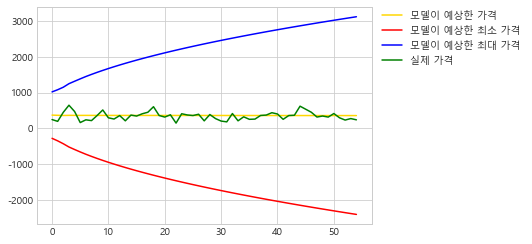

In [163]:
# 테스트 데이터셋을 불러옵니다.

pred_y = forecast_data[0].tolist() # 마지막 5일의 예측 데이터입니다. (2018-08-27 ~ 2018-08-31)
#test_data_tail = train_data.tail(5) # 실제 5일 가격 데이터입니다. (2018-08-27 ~ 2018-08-31)
test_y = test_data.values
pred_y_lower = [] # 마지막 5일의 예측 데이터의 최소값입니다.
pred_y_upper = [] # 마지막 5일의 예측 데이터의 최대값입니다.
for lower_upper in forecast_data[2]:
    lower = lower_upper[0]
    upper = lower_upper[1]
    pred_y_lower.append(lower)
    pred_y_upper.append(upper)
    
plt.plot(pred_y, color="gold", label='모델이 예상한 가격') # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red",label='모델이 예상한 최소 가격') # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue",label='모델이 예상한 최대 가격') # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green",label='실제 가격') # 실제 가격 그래프입니다.
plt.legend(bbox_to_anchor=(1.02,1), loc=2, borderaxespad=0.)
plt.savefig(f'train_data_arima_{FEATURENAME}.png')

In [142]:
auto_arima_model = auto_arima(train_data, start_p = 1, start_q=1,
                             max_p=10, max_q=10, m=12, seasonal=True,
                             max_P=5, max_Q=5, 
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=False)

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16462.940, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=16015.585, Time=0.83 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=15824.798, Time=2.74 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=15750.072, Time=10.00 sec
 ARIMA(0,0,0)(0,0,4)[12] intercept   : AIC=15688.910, Time=21.31 sec
 ARIMA(0,0,0)(0,0,5)[12] intercept   : AIC=15633.463, Time=39.03 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=15649.227, Time=1.44 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=15822.966, Time=2.73 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=15816.962, Time=5.95 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=15747.114, Time=21.05 sec
 ARIMA(0,0,0)(1,0,4)[12] intercept   : AIC=15688.449, Time=37.98 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=15601.775, Time=6.68 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=6.87 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=9.94 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=37

 ARIMA(4,0,0)(0,0,1)[12] intercept   : AIC=15009.575, Time=1.02 sec
 ARIMA(4,0,0)(1,0,0)[12] intercept   : AIC=15009.583, Time=2.32 sec
 ARIMA(4,0,1)(0,0,0)[12] intercept   : AIC=14942.295, Time=1.77 sec
 ARIMA(5,0,0)(0,0,0)[12] intercept   : AIC=14989.462, Time=0.52 sec

Best model:  ARIMA(1,0,3)(0,0,0)[12] intercept
Total fit time: 1327.425 seconds


In [157]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1041
Model:               SARIMAX(1, 0, 3)   Log Likelihood               -7464.194
Date:                Thu, 10 Dec 2020   AIC                          14940.388
Time:                        15:21:00   BIC                          14970.076
Sample:                             0   HQIC                         14951.650
                               - 1041                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.8163      7.091      0.961      0.336      -7.082      20.715
ar.L1          0.9923      0.005    202.051      0.000       0.983       1.002
ma.L1         -0.6638      0.024    -28.037      0.000      -0.710      -0.617
ma.L2         -0.0365      0.030     -1.212      0.226      -0.096       0.023
ma.L3         -0.0668      0.026     -2.595      0.009      -0.117      -0.016
sigma2      9.877e+04   2942.008     33.572      0.000     9.3e+04    1.05e+05
===================================================================================
Ljung-Box (Q):                       79.58   Jarque-Bera (JB):               341.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [158]:
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True) #
predicted_value = prediction[0]
predicted_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index = list(test_data.index)
predict_index[0]

Timestamp('2018-11-07 00:00:00+0000', tz='UTC')

In [68]:
prediction

(array([1479.38625539, 1396.66471895, 1352.63198075, 1421.79473324,
        1414.457177  , 1426.40688738, 1429.89908272, 1426.15562074,
        1426.98830334, 1426.82704823]),
 array([[ 884.72975675, 2074.04275403],
        [ 767.54661608, 2025.78282183],
        [ 699.85308865, 2005.41087285],
        [ 756.3287959 , 2087.26067059],
        [ 743.53928466, 2085.37506934],
        [ 746.0546738 , 2106.75910097],
        [ 739.10638685, 2120.6917786 ],
        [ 723.69599373, 2128.61524775],
        [ 712.30407756, 2141.67252912],
        [ 700.44831367, 2153.20578279]]))

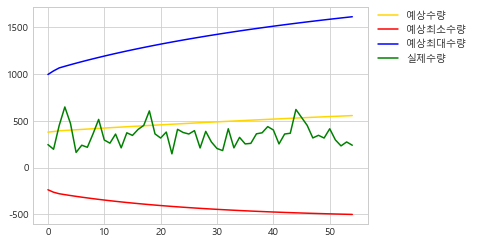

In [180]:
# 테스트 데이터셋을 불러옵니다.

pred_y = prediction[0].tolist() # 마지막 10일의 예측 데이터입니다. 
#test_data_tail = test_data.tail(10) # 실제 10일 가격 데이터입니다. 
test_y = test_data.values

pred_y_lower = prediction[1][:,0] # 마지막 10일의 예측 데이터의 최소값입니다.
pred_y_upper = prediction[1][:,1] # 마지막 10일의 예측 데이터의 최대값입니다.

plt.plot(pred_y, color="gold", label='예상수량') # 모델이 예상한 가격 그래프입니다.
plt.plot(pred_y_lower, color="red",label='예상최소수량') # 모델이 예상한 최소가격 그래프입니다.
plt.plot(pred_y_upper, color="blue",label='예상최대수량') # 모델이 예상한 최대가격 그래프입니다.
plt.plot(test_y, color="green",label='실제수량') # 실제 가격 그래프입니다.
plt.legend(bbox_to_anchor=(1.02,1), loc=2, borderaxespad=0.)
plt.savefig(f'train_data_auto_arima_{FEATURENAME}.png')



In [108]:
test_data_tail.index[0]
#train_data.tail(10)

Timestamp('2018-12-22 00:00:00+0000', tz='UTC')

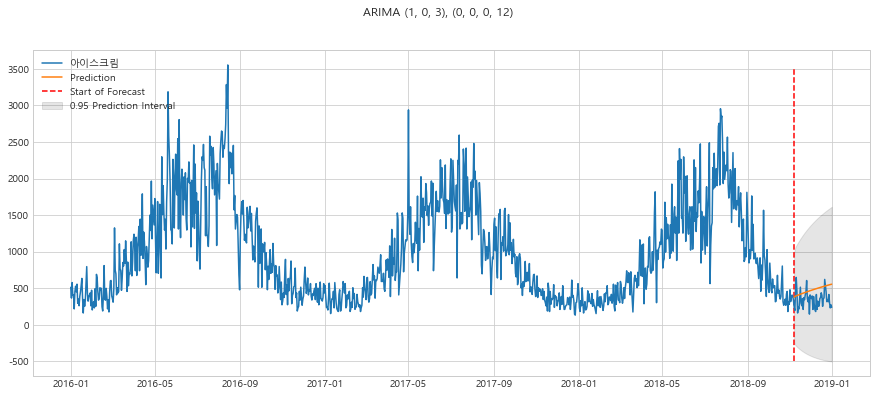

In [170]:
fig, ax = plt.subplots(figsize=(15,6))
plt.plot(date_feature, label=FEATURENAME)
plt.vlines(predict_index[0], -500,3500, linestyle='--', color='r', label='Start of Forecast')
plt.plot(predict_index, predicted_value,label='Prediction')
plt.fill_between(predict_index, predicted_ub, predicted_lb, color='k', alpha=0.1, label="0.95 Prediction Interval")
plt.legend(loc="upper left")
plt.suptitle(f'ARIMA {auto_arima_model.order}, {auto_arima_model.seasonal_order}')
#plt.show()
plt.savefig(f'test_data_predict_{FEATURENAME}.png')

In [215]:
from sklearn.tree import DecisionTreeRegressor

X = new_date_rename.loc[:,('평균기온',	'평균상대습도',	'평균풍속',	'합계강수량')]
y = new_date_rename.loc[:,'우산']
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(max_depth=6, random_state=42)

In [193]:
new_date_rename.columns[1:5]

Index(['평균기온', '평균상대습도', '평균풍속', '합계강수량'], dtype='object')

In [218]:
>>> from sklearn.tree import DecisionTreeRegressor
>>> from sklearn.tree import export_text

>>> decision_tree = DecisionTreeRegressor(random_state=0, max_depth=6)
>>> decision_tree = decision_tree.fit(X, y)
>>> r = export_text(decision_tree, feature_names=['평균기온','평균상대습도','평균풍속','합계강수량'])
>>> print(r)


|--- 합계강수량 <= 0.75
|   |--- 합계강수량 <= 0.25
|   |   |--- 평균상대습도 <= 66.50
|   |   |   |--- 평균상대습도 <= 54.50
|   |   |   |   |--- 평균기온 <= 23.15
|   |   |   |   |   |--- 평균상대습도 <= 50.50
|   |   |   |   |   |   |--- value: [1.27]
|   |   |   |   |   |--- 평균상대습도 >  50.50
|   |   |   |   |   |   |--- value: [4.27]
|   |   |   |   |--- 평균기온 >  23.15
|   |   |   |   |   |--- 평균풍속 <= 2.05
|   |   |   |   |   |   |--- value: [2.10]
|   |   |   |   |   |--- 평균풍속 >  2.05
|   |   |   |   |   |   |--- value: [21.58]
|   |   |   |--- 평균상대습도 >  54.50
|   |   |   |   |--- 평균풍속 <= 3.15
|   |   |   |   |   |--- 평균풍속 <= 1.05
|   |   |   |   |   |   |--- value: [34.00]
|   |   |   |   |   |--- 평균풍속 >  1.05
|   |   |   |   |   |   |--- value: [6.50]
|   |   |   |   |--- 평균풍속 >  3.15
|   |   |   |   |   |--- 평균풍속 <= 3.25
|   |   |   |   |   |   |--- value: [151.50]
|   |   |   |   |   |--- 평균풍속 >  3.25
|   |   |   |   |   |   |--- value: [5.00]
|   |   |--- 평균상대습도 >  66.50
|   |   |   |--- 평균기온 <= 13.15
|   |  

In [21]:
new_date_rename.columns[-2]

'우산'

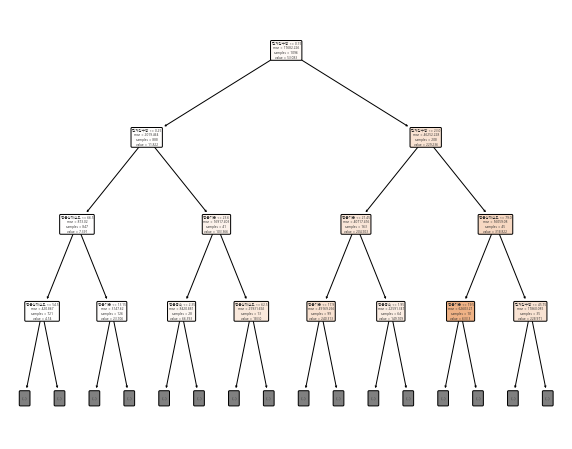

In [220]:
from sklearn.tree import plot_tree

plt.figure(figsize=(10,8))
plot_tree(tree_reg, filled=True,  rounded=True,
         feature_names= new_date_rename.columns[1:5],
         class_names=  new_date_rename.columns[-2],
          max_depth=3
         ) #  를 속성으로 줄 수 있다. 
                                        #모델의 depth가 무한대로 깊더라도 depth를 제한해서 출력해서 보여준다.

#plt.show()
#dot 파일로 export하지 않고도 그릴 수 있다. 
plt.savefig(f'decision_tree_{FEATURENAME}.png')